<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/multi_class_U_Net_Model_(11_march_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# multi-class u-net model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
pip install rasterio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 43.8 MB/s eta 0:00:00


In [4]:
import rasterio

In [5]:
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
import rasterio
import tensorflow as tf
from tensorflow.keras.models import load_model

In [6]:
from sklearn.model_selection import train_test_split
import shutil

OneYear data loading

In [165]:
directory_path = "/content/drive/MyDrive/data/images/x_training/1year"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 199 files in /content/drive/MyDrive/data/images/x_training/1year.


In [166]:
directory_path = "/content/drive/MyDrive/data/labels/y_training"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 199 files in /content/drive/MyDrive/data/labels/y_training.


In [167]:
# Ensure the lists are sorted so that images and labels correspond to each other
x_training = sorted(glob.glob(f"/content/drive/MyDrive/data/images/x_training/1year/*.tif"))
y_training = sorted(glob.glob(f"/content/drive/MyDrive/data/labels/y_training/*.tif"))

# Split the file paths into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x_training, y_training, test_size=0.2, random_state=99)

In [46]:
# N = 50
# nu = 5

# random_train_indices = np.random.choice(len(x_train), N, replace=False)
# random_test_indices = np.random.choice(len(x_test), nu, replace=False)

# # Subset the data using these random indices
# subset_x_train = [x_train[i] for i in random_train_indices]
# subset_y_train = [y_train[i] for i in random_train_indices]
# subset_x_test = [x_test[i] for i in random_test_indices]
# subset_y_test = [y_test[i] for i in random_test_indices]

In [168]:
destination = '/content/y_test_one'
os.makedirs(destination, exist_ok=True)
for file in y_test:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/y_test_one"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/labels/y_training/208_multi_wl.tif to /content/y_test_one/208_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/316_multi_wl.tif to /content/y_test_one/316_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/827_multi_wl.tif to /content/y_test_one/827_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/1593_multi_wl.tif to /content/y_test_one/1593_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/863_multi_wl.tif to /content/y_test_one/863_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/1554_multi_wl.tif to /content/y_test_one/1554_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/172_multi_wl.tif to /content/y_test_one/172_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/1594_multi_wl.tif to /content/y_test_one/1594_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/761_multi_wl.tif to /content/y_test_one/761_multi_wl.tif
Copi

In [169]:
destination = '/content/y_train_one'
os.makedirs(destination, exist_ok=True)
for file in y_train:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/y_train_one"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/labels/y_training/785_multi_wl.tif to /content/y_train_one/785_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/798_multi_wl.tif to /content/y_train_one/798_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/282_multi_wl.tif to /content/y_train_one/282_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/127_multi_wl.tif to /content/y_train_one/127_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/250_multi_wl.tif to /content/y_train_one/250_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/188_multi_wl.tif to /content/y_train_one/188_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/143_multi_wl.tif to /content/y_train_one/143_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/780_multi_wl.tif to /content/y_train_one/780_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training/331_multi_wl.tif to /content/y_train_one/331_multi_wl.tif
C

In [170]:
destination = '/content/x_test_one'
os.makedirs(destination, exist_ok=True)
for file in x_test:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/x_test_one"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/images/x_training/1year/208_1year.tif to /content/x_test_one/208_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/316_1year.tif to /content/x_test_one/316_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/827_1year.tif to /content/x_test_one/827_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/1593_1year.tif to /content/x_test_one/1593_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/863_1year.tif to /content/x_test_one/863_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/1554_1year.tif to /content/x_test_one/1554_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/172_1year.tif to /content/x_test_one/172_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/1594_1year.tif to /content/x_test_one/1594_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/761_1year.tif to /content/x_test_one/761_1year.tif
Copi

In [171]:
destination = '/content/x_train_one'
os.makedirs(destination, exist_ok=True)
for file in x_train:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/x_train_one"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/images/x_training/1year/785_1year.tif to /content/x_train_one/785_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/798_1year.tif to /content/x_train_one/798_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/282_1year.tif to /content/x_train_one/282_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/127_1year.tif to /content/x_train_one/127_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/250_1year.tif to /content/x_train_one/250_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/188_1year.tif to /content/x_train_one/188_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/143_1year.tif to /content/x_train_one/143_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/780_1year.tif to /content/x_train_one/780_1year.tif
Copied /content/drive/MyDrive/data/images/x_training/1year/331_1year.tif to /content/x_train_one/331_1year.tif
C

In [172]:
one_x_train = sorted(glob.glob(f"/content/x_train_one/*.tif"))
y_train = sorted(glob.glob(f"/content/y_train_one/*.tif"))

one_x_test = sorted(glob.glob(f"/content/x_test_one/*.tif"))
y_test= sorted(glob.glob(f"/content/y_test_one/*.tif"))

In [173]:
print(f"there are {len(one_x_train)} images for training")
print(f"there are {len(y_train)} labels for training")
print(f"there are {len(one_x_test)} images for validation")
print(f"there are {len(y_test)} labels for validation")

there are 159 images for training
there are 159 labels for training
there are 40 images for validation
there are 40 labels for validation


same from here

In [53]:
# # for 1 year images - this works dont f it up
# def read_multi_image(file_path):
#     with rasterio.open(file_path) as src:
#       bands = [src.read(i) for i in range(1,5)]

#       image = np.stack(bands, axis=-1)

#       image = image.astype(float)
#       max_value = image.max(axis=(0,1), keepdims=True)
#       min_value = image.min(axis=(0,1), keepdims=True)
#       image = (image - min_value) / (max_value - min_value)

#       return image

In [174]:
# for 1 year images - this with handling of band 5
def read_multi_image_withfive(file_path):
    with rasterio.open(file_path) as src:
      bands = [src.read(i) for i in range(1,5)]

      image = np.stack(bands, axis=-1)

      image = image.astype(float)
      max_value = image.max(axis=(0,1), keepdims=True)
      min_value = image.min(axis=(0,1), keepdims=True)
      image = (image - min_value) / (max_value - min_value)

      band_five = src.read(5)

      band_five = band_five.astype(float) /band_five.max()
      band_five = np.expand_dims(band_five, axis=-1)
      combined_image = np.concatenate([image, band_five], axis=-1)


      return combined_image

In [131]:
# for 1 year images - this with handling of band 5
def read_nine_band_image(file_path):
    with rasterio.open(file_path) as src:
      bands = [src.read(i) for i in range(1,9)]

      image = np.stack(bands, axis=-1)

      image = image.astype(float)
      max_value = image.max(axis=(0,1), keepdims=True)
      min_value = image.min(axis=(0,1), keepdims=True)
      image = (image - min_value) / (max_value - min_value)

      band_five = src.read(9)

      band_five = band_five.astype(float) /band_five.max()
      band_five = np.expand_dims(band_five, axis=-1)
      combined_image = np.concatenate([image, band_five], axis=-1)


      return combined_image

In [132]:
# for 1 year images - this with handling of band 5
def read_thirteen_band_image(file_path):
    with rasterio.open(file_path) as src:
      bands = [src.read(i) for i in range(1,13)]

      image = np.stack(bands, axis=-1)

      image = image.astype(float)
      max_value = image.max(axis=(0,1), keepdims=True)
      min_value = image.min(axis=(0,1), keepdims=True)
      image = (image - min_value) / (max_value - min_value)

      band_five = src.read(13)

      band_five = band_five.astype(float) /band_five.max()
      band_five = np.expand_dims(band_five, axis=-1)
      combined_image = np.concatenate([image, band_five], axis=-1)


      return combined_image

In [56]:
# def preprocess_data(image_path):
#     with rasterio.open(image_path) as src:
#         # Read the first four bands, assuming we drop the fifth band
#         image = src.read([1, 2, 3, 4])  # Adjust the indices based on which bands you need
#         image = np.transpose(image, (1, 2, 0))  # Reorder dimensions to (height, width, channels)
#     return image

# # Then use this function to load your images:
# x_train = np.array([preprocess_data(path) for path in train_paths])
# x_test = np.array([preprocess_data(path) for path in test_paths])


In [57]:
# pre_x_train = np.array([preprocess_data(path) for path in subset_x_train])

In [175]:
def read_image_labels(file_path):
    with rasterio.open(file_path) as src:
      label_image = src.read(1) # read the sing band
      return label_image.astype(np.int32) # ensuring labels are interger type

In [176]:
# lets read and process image data for the subsets using read_multi_image to convert
# each path in the subset into useable data array for x and y data

one_x_train_data = [read_multi_image_withfive(file_path) for file_path in one_x_train]
one_x_test_data = [read_multi_image_withfive(file_path) for file_path in one_x_test]
y_train_data = [read_image_labels(file_path) for file_path in y_train]
y_test_data = [read_image_labels(file_path) for file_path in y_test]
print(type(one_x_train_data))
print(type(y_train_data))

<class 'list'>
<class 'list'>


In [60]:
# subset_x_train_data[3] # 0.06685982, 0.09896104, 0.07385445, 0.39563863

In [61]:
# three_x_train_data = [read_thirteen_band_image(file_path) for file_path in three_x_train]
# three_x_test_data = [read_thirteen_band_image(file_path) for file_path in three_x_test]
# y_train_data = [read_image_labels(file_path) for file_path in y_train]
# y_test_data = [read_image_labels(file_path) for file_path in y_test]
# subset_x_train_data[3] # 0.06685982, 0.09896104, 0.07385445, 0.39563863, 0.21425932

In [134]:
# two_x_train_data = [read_nine_band_image(file_path) for file_path in two_x_train]
# two_x_test_data = [read_nine_band_image(file_path) for file_path in two_x_test]
# y_train_data = [read_image_labels(file_path) for file_path in y_train]
# y_test_data = [read_image_labels(file_path) for file_path in y_test]

In [177]:
one_x_train_data[4]

array([[[0.11865149, 0.18929016, 0.17151556, 0.71691792, 0.14809967],
        [0.11865149, 0.18929016, 0.17151556, 0.71691792, 0.14809967],
        [0.11865149, 0.18929016, 0.17151556, 0.71691792, 0.14809967],
        ...,
        [0.14711033, 0.20880033, 0.20771313, 0.42019622, 0.8594983 ],
        [0.14711033, 0.20880033, 0.20771313, 0.42019622, 0.8594983 ],
        [0.14711033, 0.20880033, 0.20771313, 0.42019622, 0.8594983 ]],

       [[0.11865149, 0.18929016, 0.17151556, 0.71691792, 0.14809967],
        [0.11865149, 0.18929016, 0.17151556, 0.71691792, 0.14809967],
        [0.11865149, 0.18929016, 0.17151556, 0.71691792, 0.14809967],
        ...,
        [0.14711033, 0.20880033, 0.20771313, 0.42019622, 0.8594983 ],
        [0.14711033, 0.20880033, 0.20771313, 0.42019622, 0.8594983 ],
        [0.14711033, 0.20880033, 0.20771313, 0.42019622, 0.8594983 ]],

       [[0.11865149, 0.18929016, 0.17151556, 0.71691792, 0.14809967],
        [0.11865149, 0.18929016, 0.17151556, 0.71691792, 0.1

In [178]:
# # Example: Check the first element to see its unique values and shape
print("Unique labels y_train image:", np.unique(y_train_data[3]))
print("Shape of y_train image:", y_test_data[8].shape)
print("Shape of x_train image:", one_x_train_data[8].shape)


Unique labels y_train image: [2 6 7]
Shape of y_train image: (384, 384)
Shape of x_train image: (384, 384, 5)


In [179]:
one_x_train = np.array(one_x_train_data)
one_x_test = np.array(one_x_test_data)
y_train = np.array(y_train_data)
y_test = np.array(y_test_data)
print(type(two_x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [180]:
print(one_x_train.shape)
print(one_x_test.shape)
print(y_train.shape)
print(y_test.shape)

(159, 384, 384, 5)
(40, 384, 384, 5)
(159, 384, 384)
(40, 384, 384)


In [181]:
from tensorflow.keras.utils import to_categorical

In [182]:
y_train_shifted = y_train -1
y_test_shifted = y_test -1

In [183]:
print(y_train_shifted.shape)
print(y_test_shifted.shape)

(159, 384, 384)
(40, 384, 384)


In [184]:
y_train_encoded = to_categorical(y_train_shifted, num_classes = 7)
y_test_encoded = to_categorical(y_test_shifted, num_classes = 7)

In [185]:
print(y_train_encoded.shape)
print(y_test_encoded.shape)

(159, 384, 384, 7)
(40, 384, 384, 7)


In [186]:
print(one_x_train.shape)
print(one_x_test.shape)

(159, 384, 384, 5)
(40, 384, 384, 5)


In [187]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet_model(input_size=(384, 384, 5), num_classes=7):
    inputs = Input(input_size)

    # Downsampling (Contracting Path)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)

    # Upsampling (Expanding Path)
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model
model = unet_model()


In [188]:
print(model.input)
print(model.output)


KerasTensor(type_spec=TensorSpec(shape=(None, 384, 384, 5), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 384, 384, 7), dtype=tf.float32, name=None), name='conv2d_43/Softmax:0', description="created by layer 'conv2d_43'")


In [189]:
print(model.summary()) # oneYear = 1,889,799  twoyear 1,892,103  threeyear 1,894,407

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 384, 384, 5)]        0         []                            
                                                                                                  
 conv2d_33 (Conv2D)          (None, 384, 384, 64)         2944      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 384, 384, 64)         256       ['conv2d_33[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_15 (Dropout)        (None, 384, 384, 64)         0         ['batch_normalization_30

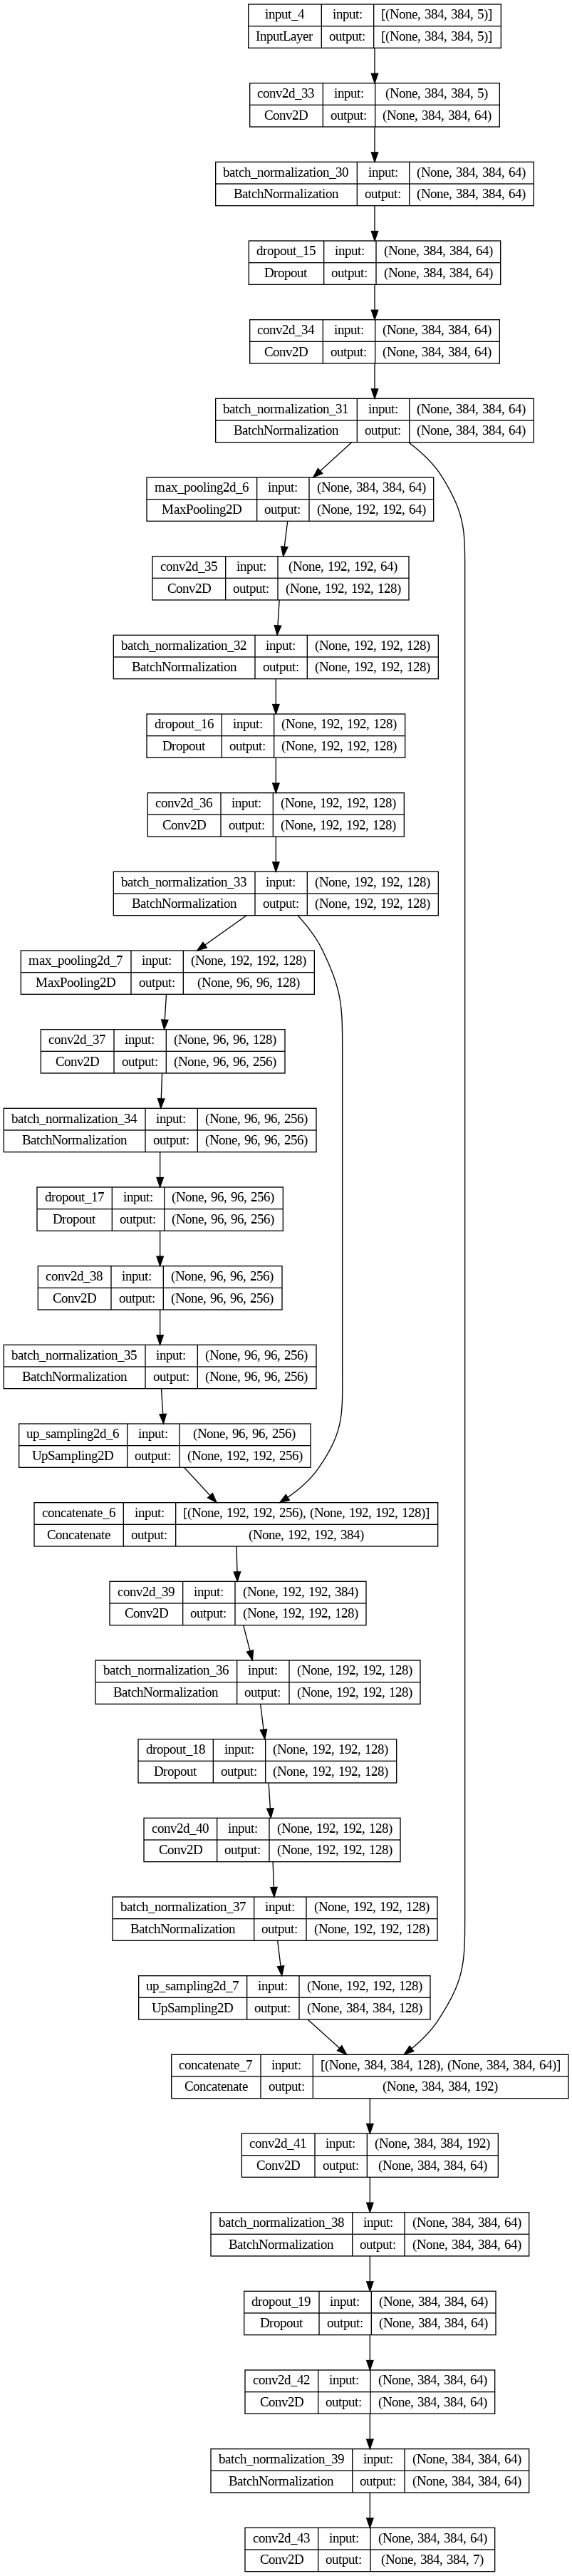

In [190]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model_plot_oneyears.png", show_shapes=True, show_layer_names=True)

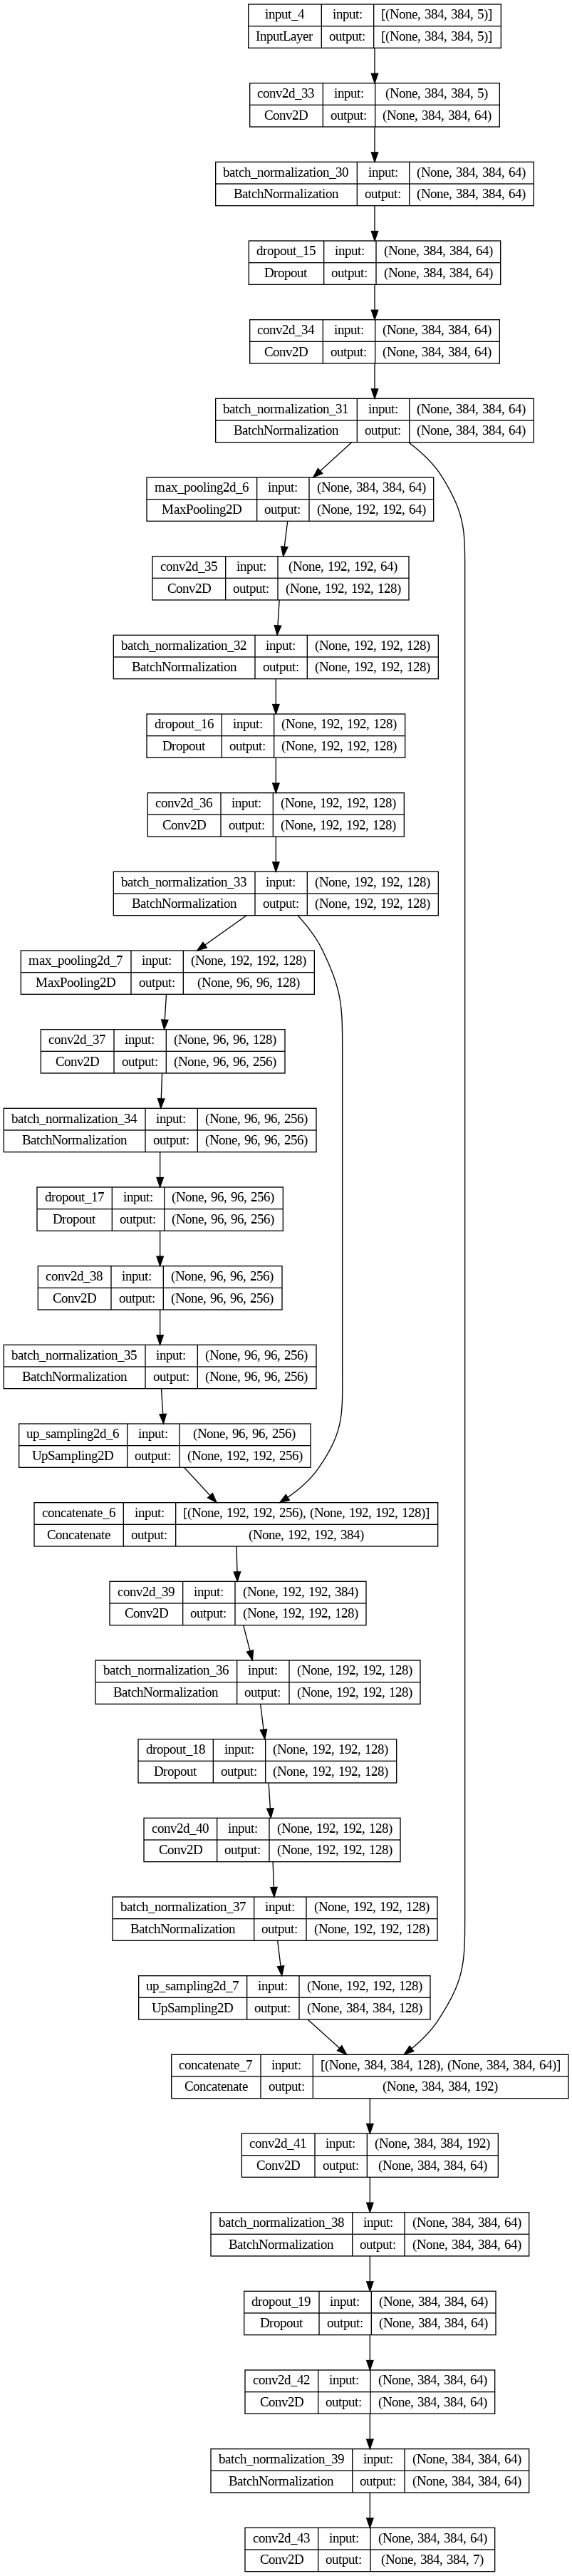

In [191]:
from IPython.display import Image

# Display the image in Jupyter notebook
Image(filename='model_plot_oneyears.png')

# Compile, fit and predict on test_dataset

In [192]:
import tensorflow as tf
from tensorflow import keras
import shutil
import zipfile

In [75]:
# def read_multi_image_withfive(file_path):
#     with rasterio.open(file_path) as src:
#       bands = [src.read(i) for i in range(1,5)]
#       image = np.stack(bands, axis=-1)
#       image = image.astype(float)
#       max_value = image.max(axis=(0,1), keepdims=True)
#       min_value = image.min(axis=(0,1), keepdims=True)
#       image = (image - min_value) / (max_value - min_value)
#       band_five = src.read(5)
#       band_five = band_five.astype(float) /band_five.max()
#       band_five = np.expand_dims(band_five, axis=-1)
#       combined_image = np.concatenate([image, band_five], axis=-1)
#       return combined_image

In [194]:
class SavePredictionCallback(Callback):
    def __init__(self, x_holdout_dir, output_folder, model_input_size, epoch_frequency=5):
        self.x_holdout_dir = glob.glob(x_holdout_dir)  # Get all file paths matching the pattern
        self.output_folder = output_folder
        self.model_input_size = model_input_size
        self.epoch_frequency = epoch_frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_frequency == 0:
            for image_path in self.x_holdout_dir:
                # Read the image with rasterio
                with rasterio.open(image_path) as src:
                    bands = [src.read(i) for i in range(1, 5)]
                    image = np.stack(bands, axis=-1)
                    image = image.astype(float)
                    max_value = image.max(axis=(0, 1), keepdims=True)
                    min_value = image.min(axis=(0, 1), keepdims=True)
                    image = (image - min_value) / (max_value - min_value)
                    band_five = src.read(5)
                    band_five = band_five.astype(float) / band_five.max()
                    band_five = np.expand_dims(band_five, axis=-1)
                    combined_image = np.concatenate([image, band_five], axis=-1)
                    combined_image_batch = np.expand_dims(combined_image, axis=0)
                    # image = src.read()  # Read all bands
                    # image = np.transpose(image, (1, 2, 0))  # Reorder dimensions to (height, width, channels)
                    # image = np.expand_dims(image, axis=-1)  # Add batch dimension
                    # image = image.astype(np.float32) / 255.0  # Normalize the image if needed

                # Predict using the model
                prediction = self.model.predict(combined_image_batch)
                prediction_image = np.argmax(prediction, axis=-1)[0, :, :]# Get the predicted class for each pixel

                # Prepare the output path
                output_path = os.path.join(self.output_folder, f"epoch_{epoch+1}_{os.path.basename(image_path)}")

                # Save the prediction using rasterio
                meta = src.meta.copy()
                meta.update(dtype=rasterio.uint8, count=1, compress='lzw', nodata= None)  # Set metadata for output
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(prediction_image.astype(rasterio.uint8), 1)

# Initialization of the callback
img_height, img_width = 384, 384
output_folder = "/content/drive/MyDrive/data/model_prediction/oneyear_data/20240417_1425"
os.makedirs(output_folder, exist_ok=True)  # Ensure the output directory exists
x_holdout_dir = "/content/drive/MyDrive/data/images/x_test/1year/*.tif"

savepred_callback = SavePredictionCallback(
    x_holdout_dir=x_holdout_dir,
    output_folder=output_folder,
    model_input_size = (img_height, img_width),
    epoch_frequency=5
)


In [195]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'categorical_accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "/content/drive/MyDrive/data/model_prediction/oneyear_data/20240417_1425/20240417_1425.h5", monitor = 'val_loss', save_best_only = True), savepred_callback]

In [78]:
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'categorical_accuracy'])
# callbacks = [keras.callbacks.ModelCheckpoint(filepath = "/content/drive/MyDrive/data/model_prediction/20240416_1600/20240416_1600.h5", monitor = 'val_loss', save_best_only = True)]

In [196]:
model.fit(one_x_train, y_train_encoded, batch_size=8, epochs=500, validation_data=(one_x_test, y_test_encoded),
          callbacks=[callbacks])

Epoch 1/500
 6/20 [========>.....................] - ETA: 16s - loss: 2.3899 - accuracy: 0.2130 - categorical_accuracy: 0.2130

20/20 [==============================] - 40s 2s/step - loss: 2.0753 - accuracy: 0.3217 - categorical_accuracy: 0.3217 - val_loss: 31.1066 - val_accuracy: 0.7061 - val_categorical_accuracy: 0.7061
Epoch 2/500
20/20 [==============================] - 26s 1s/step - loss: 1.7476 - accuracy: 0.4713 - categorical_accuracy: 0.4713 - val_loss: 8.9947 - val_accuracy: 0.1268 - val_categorical_accuracy: 0.1268
Epoch 3/500
20/20 [==============================] - 26s 1s/step - loss: 1.5354 - accuracy: 0.6462 - categorical_accuracy: 0.6462 - val_loss: 2.9579 - val_accuracy: 0.3523 - val_categorical_accuracy: 0.3523
Epoch 4/500
20/20 [==============================] - 27s 1s/step - loss: 1.3974 - accuracy: 0.6942 - categorical_accuracy: 0.6942 - val_loss: 2.9182 - val_accuracy: 0.2694 - val_categorical_accuracy: 0.2694
Epoch 5/500
20/20 [==============================] - 26s 1s/step - loss: 1.2146 - accuracy: 0.7452 - categorical_accuracy: 0.7452 - val_loss: 1.4647 - val_accuracy: 0.5255 - val_categ

In [80]:

# model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
# callbacks = [
#     keras.callbacks.ModelCheckpoint(filepath='/content/validation_prediction_3year/model_3year_20240415_1835.h5', monitor = 'val_loss', save_best_only=True),
#     save_pred_callback
# ]

In [ ]:

# vguikuytfyu
# def zip_folder(folder_path, output_zip_path):
#     """Zips the contents of a folder into a zip file.

#     Args:
#         folder_path: The path to the folder to be zipped.
#         output_zip_path: The path to the output zip file.
#     """

#     with zipfile.ZipFile(output_zip_path, "w") as zip_file:
#         for root, dirs, files in os.walk(folder_path):
#             for file in files:
#                 file_path = os.path.join(root, file)
#                 zip_file.write(file_path)

# if __name__ == "__main__":
#     folder_path = "/content/validation_prediction_3year" #Souce folder
#     output_zip_path = "/content/drive/MyDrive/data/working_dir_3year/model_3year_20240415_1835/model_3year_20240415_1835.zip" #zip file

#     zip_folder(folder_path, output_zip_path)

In [ ]:
# import shutil
# import os

# def delete_folder(path):
#     """Deletes a folder at a specified path along with all its contents."""
#     try:
#         shutil.rmtree(path)
#         print(f"Folder '{path}' has been deleted successfully.")
#     except Exception as e:
#         print(f"Failed to delete folder '{path}'. Reason: {e}")

# # Specify the path to the directory you want to delete
# folder_path = '/content/validation_images_THREE'

# # Check if the folder exists then delete
# if os.path.exists(folder_path):
#     delete_folder(folder_path)
# else:
#     print(f"No folder found at {folder_path}")


# using the model to predict


Only thing on here is the predict and save for the final model prediction.

In [156]:
# import matplotlib.pyplot as plt
# import numpy as np
# import rasterio
# from tensorflow.keras.preprocessing.image import array_to_img
# import PIL.ImageOps
# from PIL import Image
# import matplotlib.patches as mpatches
# import matplotlib.colors as mcolors

# class_names = ['Unclassified', 'Water', 'Forested Wetland', 'Emergent Wetland', 'Forested/Shrub Wetland', 'Aquatic Bed', 'Developed', 'Agriculture', 'Grassland', 'Forest', 'Shrubland']
# colors = ['dimgrey', 'cornflowerblue', 'violet', 'teal', 'orange', 'mediumblue', 'lightgrey', 'saddlebrown', 'wheat', 'lightyellow', 'forestgreen', 'peru']
# cmap = mcolors.ListedColormap(colors)


In [158]:
from tensorflow.keras.models import load_model

# Replace 'path/to/your/model.h5' with the actual path to your saved model
model = load_model('/content/drive/MyDrive/data/model_prediction/twoyear_data/20240417_0937/20240417_0937.h5')


In [161]:
from tensorflow.image import resize

def load_and_preprocess_image(image_path, expected_size):
    with rasterio.open(image_path) as src:
        # Read the imagery tile, assuming it's multi-band
        image = src.read()
        if image.shape[0] > 9:
            image = image[:9, :, :]
        image = np.transpose(image, (1, 2, 0))
        image = resize(image, [expected_size, expected_size])

        image = image / 2555.0  # Adjust based on your normalization method
        image = np.expand_dims(image, axis=0)
        return image



# def load_and_process(image_path):
#   with rasterio.open(image_path) as src:
#     bands = [src.read(i) for i in range(1, 13)]
#     image = np.stack(bands, axis=-1)
#     image = image.astype(float)
#     max_value = image.max(axis=(0, 1), keepdims=True)
#     min_value = image.min(axis=(0, 1), keepdims=True)
#     image = (image - min_value) / (max_value - min_value)
#     band_five = src.read(13)
#     band_five = band_five.astype(float) / band_five.max()
#     band_five = np.expand_dims(band_five, axis=-1)
#     combined_image = np.concatenate([image, band_five], axis=-1)
#     combined_image_batch = np.expand_dims(combined_image, axis=0)

#     return combined_image_batch


In [162]:

image_path = "/content/x_test_two/330_2year.tif"
image_test = load_and_process(image_path)
expected_size = 384
image = load_and_preprocess_image(image_path, expected_size)


IndexError: band index 10 out of range (not in (1, 2, 3, 4, 5, 6, 7, 8, 9))

In [ ]:
image

In [108]:
prediction = model.predict(image)
predicted_mask = np.argmax(prediction, axis=-1)
predicted_mask = predicted_mask[0, :, :]

1/1 [==============================] - 0s 24ms/step


In [99]:
predicted_mask

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]])

In [88]:
pip install matplotlib

1/1 [==============================] - 1s 823ms/step


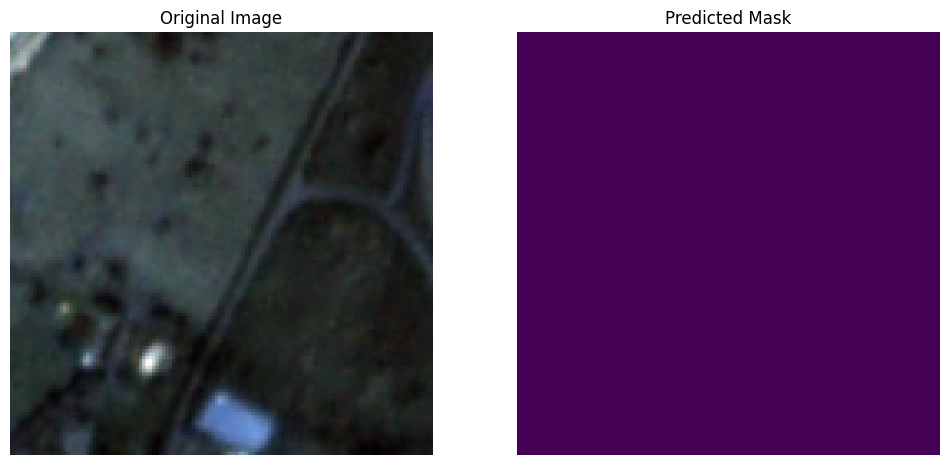

In [109]:
import matplotlib.pyplot as plt

def visualize_prediction(original_image, predicted_mask, figsize=(12, 6)):
    # If the original image has more than 3 channels, select the first three for visualization
    if original_image.shape[-1] > 3:
        original_image = original_image[:, :, :3]

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    # Display the predicted mask
    # Assuming predicted_mask is 2D (height, width), you might want to add a colormap
    axes[1].imshow(predicted_mask, cmap='viridis')  # Use a colormap that suits your task
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')
    plt.show()

prediction = model.predict(image_test)

# Convert prediction to a class mask
predicted_mask = np.argmax(prediction, axis=-1)[0, :, :]  # Remove batch dimension
# adjusted_image = np.clip(image_test, 0, 1)  # Ensure values are within [0, 1]
visualize_prediction(image_test[0], predicted_mask)

In [ ]:
# model = load_model('/content/drive/MyDrive/DeepLearning_Project/planet_ThreeYear/test_dataset/model_03222024_1255/model_03222023_1255.h5')

In [ ]:
# def predict_and_save(model, test_image_dir, model_input_size, output_folder):
#     image_files = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.tif')]

#     for image_path in image_files:
#         with rasterio.open(image_path) as src:
#             image = src.read(out_shape=(src.count, model_input_size[0], model_input_size[1]),
#                              resampling=rasterio.enums.Resampling.nearest)
#             image = np.transpose(image, (1, 2, 0))
#             image = np.expand_dims(image, axis=0)  # Add batch dimension
#             # image = image / np.max(image)  # Normalize
#             image = image / 2555.0

#             prediction = model.predict(image)
#             prediction_image = np.argmax(prediction, axis=-1)[0, :, :]
#             meta = src.meta
#             # meta.update(dtype=rasterio.uint8, count=1)
#             meta.update(dtype=rasterio.uint8, count=1, nodata=None)



#             output_path = os.path.join(output_folder, f"prediction_{os.path.basename(image_path)}")
#             with rasterio.open(output_path, 'w', **meta) as dst:
#                 dst.write(prediction_image.astype(rasterio.uint8), 1)

In [ ]:
# # Define model input size and paths
# IMG_HEIGHT, IMG_WIDTH = img_height, img_width  # Ensure these are defined or replace them with actual values
# test_image_dir = '/content/drive/MyDrive/data/working_dir_3year/hold_images/'
# output_folder = '/content/drive/MyDrive/data/working_dir_3year/model_3year_20240415_1835/'

# # /content/drive/MyDrive/DeepLearning_Project/planet_TwoYear/test_dataset/model_03222024_1255/model_03222024_1255.h5

# # Make sure the output directory exists
# os.makedirs(output_folder, exist_ok=True)

# # Execute prediction and saving
# predict_and_save(model, test_image_dir, (IMG_HEIGHT, IMG_WIDTH), output_folder)


In [118]:
# Path to the directory you want to delete
folder_path = '/content/y_train16'

# Safety check to ensure the directory exists before trying to delete
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"The folder {folder_path} has been deleted.")
else:
    print(f"The folder {folder_path} does not exist.")

The folder /content/y_train16 has been deleted.
